In [47]:
# imports 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pathlib
from datetime import datetime
from dataclasses import dataclass
import math
import pyfao56 as fao 
from eto import ETo
import sqlite3


In [21]:
#loading weather data file 
con = sqlite3.connect('solarData.sqlite')
df_weather_raw = pd.read_sql_query("SELECT * from cebiveSolarDailyHourly", con)
con.close()

df_weather_raw

,iso_date,location,lat,lon,tz,date,Year,Month,Day,Hour,...,Clear_sky.dni,Cloudy_sky.ghi,Cloudy_sky.dni,Cloudy_sky.dhi,Temp,wind_speed,wind_deg,RH,pressure,rowid
0,2010-01-01 00:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,0,...,0.0,0.0,0.0,0.0,24.60,2.70,45,80.04,1021,1
1,2010-01-01 01:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,1,...,0.0,0.0,0.0,0.0,24.00,2.50,43,83.46,1021,2
2,2010-01-01 02:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,2,...,0.0,0.0,0.0,0.0,23.50,2.30,40,86.56,1021,3
3,2010-01-01 03:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,3,...,0.0,0.0,0.0,0.0,23.30,2.20,37,87.95,1020,4
4,2010-01-01 04:00:00,CEBIVE,18.54,-69.99,-4:00,2010-01-01,2010,1,1,4,...,0.0,0.0,0.0,0.0,23.30,2.20,37,88.16,1020,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122707,2023-12-31 19:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,19,...,0.0,0.0,0.0,0.0,27.58,6.17,30,78.00,1017,122708
122708,2023-12-31 20:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,20,...,0.0,0.0,0.0,0.0,25.50,3.09,20,89.00,1017,122709
122709,2023-12-31 21:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,21,...,0.0,0.0,0.0,0.0,24.88,2.57,360,90.00,1017,122710
122710,2023-12-31 22:00:00,CEBIVE,18.54,-69.99,-4:00,2023-12-31,2023,12,31,22,...,0.0,0.0,0.0,0.0,25.09,5.14,180,90.00,1018,122711


In [59]:
#Preparing weather dataframe
df_weather = df_weather_raw.groupby('date').agg({'Temp': ['max', 'min'], 'RH': ['max', 'min'], 'pressure': 'mean', 'wind_speed': 'mean', 'Cloudy_sky.ghi': 'sum', 'Cloudy_sky.dni':'sum' })
df_weather.columns = ['T_max', 'T_min', 'RH_max', 'RH_min' ,'P','U_2', 'GHI', 'DNI']
df_weather['R_n'] = (0.77 * df_weather['GHI'] + 0.25 * df_weather['DNI']) * 3600 / 1e6 #in MJ/m2/day
df_weather.drop(columns=['GHI', 'DNI'])
df_weather.index = pd.to_datetime(df_weather.index)
df_weather

,T_max,T_min,RH_max,RH_min,P,U_2,GHI,DNI,R_n
date,,,,,,,,,
2010-01-01,31.10,22.70,93.63,51.46,1018.083333,2.175000,4257.00,5082.00,16.374204
2010-01-02,31.40,23.50,87.16,49.48,1014.583333,1.129167,4009.00,4762.00,15.398748
2010-01-03,28.40,23.30,96.27,65.83,1014.041667,1.937500,1457.00,880.00,4.830804
2010-01-04,29.80,23.10,95.53,58.61,1014.500000,1.762500,3369.00,3841.00,12.795768
2010-01-05,30.70,23.40,94.39,47.34,1015.791667,1.479167,4557.00,5862.00,17.907804
...,...,...,...,...,...,...,...,...,...
2023-12-27,29.82,20.65,94.00,70.00,1014.875000,1.360417,5106.78,7367.48,20.786726
2023-12-28,29.05,20.01,100.00,67.00,1014.125000,1.046667,3735.19,2891.50,12.956297
2023-12-29,29.20,20.01,100.00,78.00,1015.375000,0.765000,5153.47,7524.14,21.057145


the maximum ETo is 7.86 mm/day 
the minimum ETo is 1.02 mm/day 


Text(0, 0.5, 'mm/day')

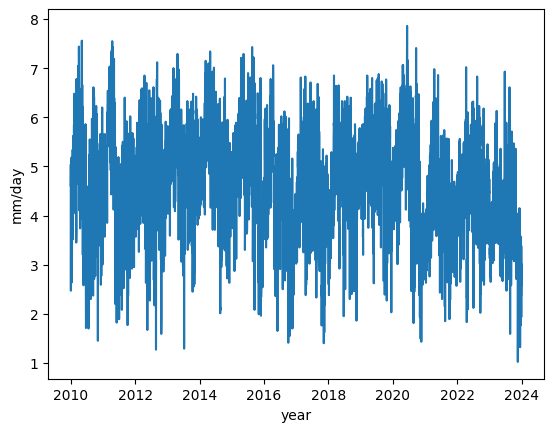

In [64]:
et1 = ETo()
et1.param_est(df= df_weather, freq='D', z_msl=10, lat=18.54, lon=-69.99, TZ_lon=-60.00, z_u=2, K_rs=0.16, a_s=0.25, b_s=0.5, alb=0.23)
et1.ts_param.head()
results = et1.eto_fao()
max_ETo = max(results)
print(f"the maximum ETo is {max_ETo} mm/day ")
min_ETo = min(results)
print(f"the minimum ETo is {min_ETo} mm/day ")
plt.plot(results)
plt.xlabel('year')
plt.ylabel('mm/day')



Text(0, 0.5, 'mm/day')

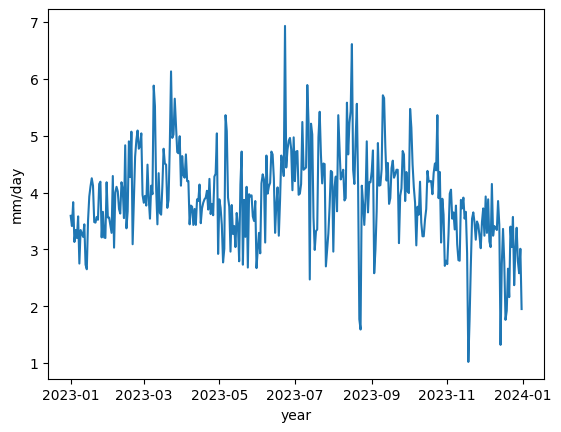

In [68]:
results_2023 = results['2023']
plt.plot(results_2023)
plt.xlabel('year')
plt.ylabel('mm/day')